In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopy.distance
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
from pandas.core.common import SettingWithCopyWarning

# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Load Data

In [2]:
from os import listdir
from os.path import isfile, join

mypath = '/data/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f)) if f.startswith('resale')]

df_hdb = pd.DataFrame()
for file in files:
    df_tmp = pd.read_csv(mypath+file)
    df_hdb = pd.concat([df_hdb,df_tmp], axis=0)
    
df_hdb = df_hdb.drop_duplicates()

df_hdb = df_hdb.loc[df_hdb['month']>='2021-01']

print(df_hdb.shape)
df_hdb.head()

(43352, 11)


month        town flat_type block       street_name storey_range  \
87589  2021-01  ANG MO KIO    2 ROOM   170  ANG MO KIO AVE 4     07 TO 09   
87590  2021-01  ANG MO KIO    2 ROOM   170  ANG MO KIO AVE 4     01 TO 03   
87591  2021-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   
87592  2021-01  ANG MO KIO    3 ROOM   223  ANG MO KIO AVE 1     07 TO 09   
87593  2021-01  ANG MO KIO    3 ROOM   223  ANG MO KIO AVE 1     10 TO 12   

       floor_area_sqm      flat_model  lease_commence_date  \
87589            45.0        Improved                 1986   
87590            45.0        Improved                 1986   
87591            73.0  New Generation                 1976   
87592            67.0  New Generation                 1978   
87593            67.0  New Generation                 1978   

          remaining_lease  resale_price  
87589   64 years 01 month      225000.0  
87590   64 years 01 month      211000.0  
87591  54 years 04 months      275888.0  
87592   56 years 01 month      316800.0  
87593            56 years      305000.0

In [3]:
df_streets = pd.read_csv(mypath+'street_name_coord.csv')
df_streets = df_streets.dropna()
df_streets.head()

street_name  latitude   longitude
0   ANG MO KIO AVE 1  1.364362  103.846005
1   ANG MO KIO AVE 3  1.370815  103.864050
2   ANG MO KIO AVE 4  1.379999  103.841407
3  ANG MO KIO AVE 10  1.362654  103.855288
4   ANG MO KIO AVE 5  1.377311  103.860486

In [4]:
df_stations = pd.read_csv(mypath+'station_coord.csv')
df_stations = df_stations.dropna()
df_stations.head()

station_name  latitude   longitude
0    Jurong East  1.333153  103.742286
1    Bukit Batok  1.349033  103.749566
2   Bukit Gombak  1.358612  103.751791
4  Choa Chu Kang  1.385363  103.744371
5        Yew Tee  1.397535  103.747405

# Transformation

In [5]:
df_hdb['storey_tmp_a'] = df_hdb['storey_range'].str.split(' ', expand=True)[0]
df_hdb['storey_tmp_b'] = df_hdb['storey_range'].str.split(' ', expand=True)[2]
df_hdb['storey_tmp_a'] = df_hdb['storey_tmp_a'].astype(int)
df_hdb['storey_tmp_b'] = df_hdb['storey_tmp_b'].astype(int)
df_hdb['storey'] = (df_hdb['storey_tmp_a']+df_hdb['storey_tmp_b'])/2

df_hdb['sqft'] = df_hdb['floor_area_sqm']*10.7639
df_hdb['psf'] = df_hdb['resale_price']/df_hdb['sqft']
df_hdb

month        town  flat_type block       street_name storey_range  \
87589   2021-01  ANG MO KIO     2 ROOM   170  ANG MO KIO AVE 4     07 TO 09   
87590   2021-01  ANG MO KIO     2 ROOM   170  ANG MO KIO AVE 4     01 TO 03   
87591   2021-01  ANG MO KIO     3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   
87592   2021-01  ANG MO KIO     3 ROOM   223  ANG MO KIO AVE 1     07 TO 09   
87593   2021-01  ANG MO KIO     3 ROOM   223  ANG MO KIO AVE 1     10 TO 12   
...         ...         ...        ...   ...               ...          ...   
130973  2022-07      YISHUN     5 ROOM   613      YISHUN ST 61     07 TO 09   
130974  2022-07      YISHUN  EXECUTIVE   361    YISHUN RING RD     01 TO 03   
130975  2022-07      YISHUN  EXECUTIVE   359    YISHUN RING RD     07 TO 09   
130976  2022-07      YISHUN  EXECUTIVE   277      YISHUN ST 22     01 TO 03   
130977  2022-07      YISHUN  EXECUTIVE   723      YISHUN ST 71     07 TO 09   

        floor_area_sqm      flat_model  lease_commence_date  \
87589             45.0        Improved                 1986   
87590             45.0        Improved                 1986   
87591             73.0  New Generation                 1976   
87592             67.0  New Generation                 1978   
87593             67.0  New Generation                 1978   
...                ...             ...                  ...   
130973           121.0        Improved                 1987   
130974           145.0      Maisonette                 1988   
130975           146.0      Maisonette                 1988   
130976           146.0      Maisonette                 1985   
130977           145.0       Apartment                 1986   

           remaining_lease  resale_price  storey_tmp_a  storey_tmp_b  storey  \
87589    64 years 01 month      225000.0             7             9     8.0   
87590    64 years 01 month      211000.0             1             3     2.0   
87591   54 years 04 months      275888.0             4             6     5.0   
87592    56 years 01 month      316800.0             7             9     8.0   
87593             56 years      305000.0            10            12    11.0   
...                    ...           ...           ...           ...     ...   
130973  63 years 10 months      580000.0             7             9     8.0   
130974            65 years      720000.0             1             3     2.0   
130975   65 years 01 month      780000.0             7             9     8.0   
130976  62 years 02 months      715000.0             1             3     2.0   
130977  62 years 11 months      720000.0             7             9     8.0   

             sqft         psf  
87589    484.3755  464.515650  
87590    484.3755  435.612454  
87591    785.7647  351.107653  
87592    721.1813  439.279277  
87593    721.1813  422.917233  
...           ...         ...  
130973  1302.4319  445.320788  
130974  1560.7655  461.312093  
130975  1571.5294  496.331790  
130976  1571.5294  454.970807  
130977  1560.7655  461.312093  

[43352 rows x 16 columns]

# EDA

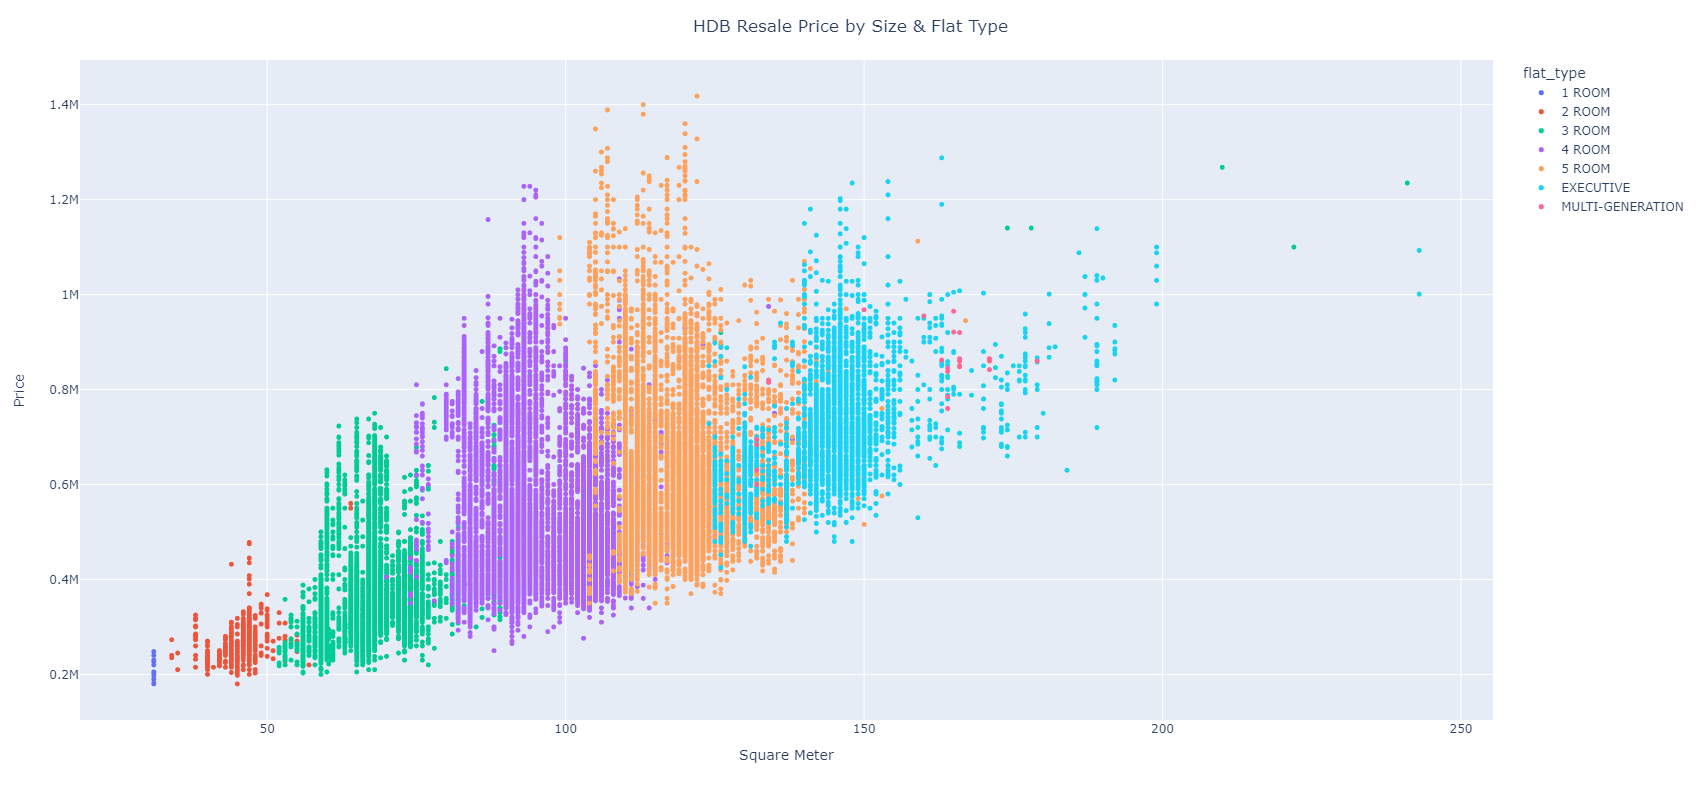

In [6]:
fig = px.scatter(df_hdb.sort_values('flat_type'), x='floor_area_sqm', y='resale_price', color='flat_type')
fig.update_layout(
    autosize=True,
    #width=1300,
    height=800,
    yaxis_title='Price',
    xaxis_title='Square Meter',
    title={
        'text': "HDB Resale Price by Size & Flat Type",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)
fig.update_traces(marker=dict(size=5),
                  selector=dict(mode='markers'))
fig.show()

In [7]:
df_town = df_hdb.groupby('town').agg(psf=('psf','mean'), year=('lease_commence_date','mean'), storey=('storey','mean'))
df_town = df_town.reset_index()
df_town

town         psf         year     storey
0        ANG MO KIO  493.654861  1984.841191   8.487593
1             BEDOK  480.532243  1986.621507   7.859018
2            BISHAN  582.029694  1989.370192   8.317308
3       BUKIT BATOK  461.427943  1992.235294   8.631317
4       BUKIT MERAH  643.767373  1992.218424  11.523175
5     BUKIT PANJANG  458.195970  2001.829639   9.972134
6       BUKIT TIMAH  614.163459  1982.689655   6.810345
7      CENTRAL AREA  768.718690  1993.525199  17.509284
8     CHOA CHU KANG  440.019463  2005.118896   8.751592
9          CLEMENTI  601.185485  1992.689655  12.183908
10          GEYLANG  536.070393  1986.431655   7.824640
11          HOUGANG  476.185669  1996.909829   7.940487
12      JURONG EAST  451.076627  1991.342615   9.569007
13      JURONG WEST  430.129659  1996.355452   7.960693
14  KALLANG/WHAMPOA  613.834277  1992.272277  11.683168
15    MARINE PARADE  570.885745  1975.395349   9.724252
16        PASIR RIS  457.161205  1996.453704   7.019231
17          PUNGGOL  505.716483  2012.571092   9.457973
18       QUEENSTOWN  700.888704  1996.119220  14.906069
19        SEMBAWANG  442.179900  2005.182440   8.690992
20         SENGKANG  483.201793  2009.333582  10.073134
21        SERANGOON  504.610199  1988.041114   6.750663
22         TAMPINES  478.333104  1993.401518   6.787529
23        TOA PAYOH  549.829465  1986.111769  10.604737
24        WOODLANDS  414.178746  1998.250399   7.338517
25           YISHUN  450.921953  1997.859993   6.967356

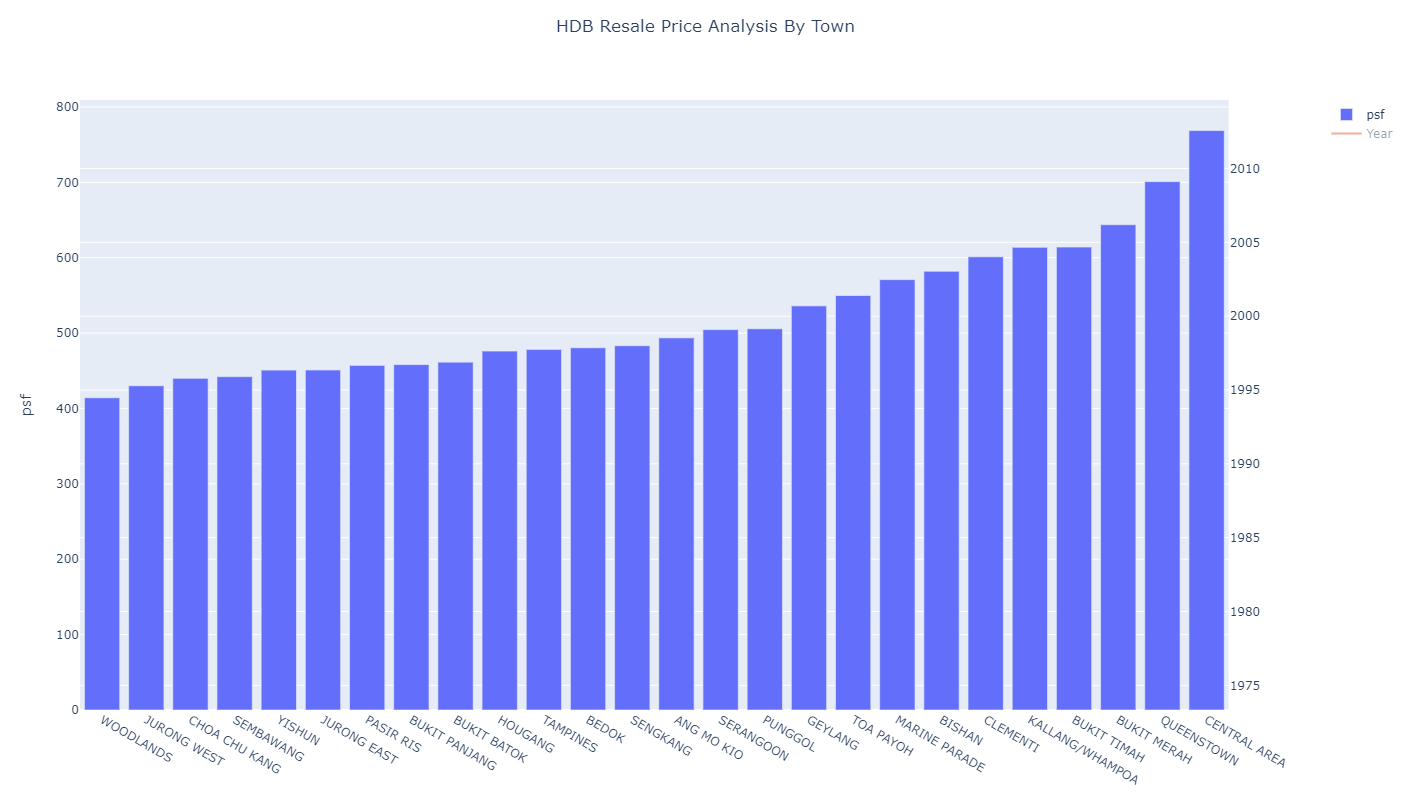

In [8]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
df_town = df_town.sort_values('psf')
fig.add_trace(go.Bar(x=df_town.town, y=df_town.psf, name='psf'), secondary_y=False)
#fig.add_trace(go.Bar(x=df_town.town, y=df_town.year, name='Year'), secondary_y=False,)
fig.add_trace(go.Scatter(x=df_town.town, y=df_town.year, mode='lines', name='Year'), secondary_y=True,)
fig.update_layout(
    autosize=True,
    #width=1300,
    height=800,
    yaxis_title='psf',
    title={
        'text': "HDB Resale Price Analysis By Town",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)
fig.show()

# Feature Engineering
1. Get coordinate of each house using API
2. Get coordinate of MRT stations using API
3. Calculate distance between each house and the nearest MRT station
3. Calculate distance between each house and town center (Orchart)

In [9]:
for index, street in df_streets.iterrows():
    street_coord = (street['latitude'], street['longitude'])
    distance = 1000
    MRT = ''
    # print(street_coord)
    for _, mrt in df_stations.iterrows():
        mrt_coord = (mrt['latitude'], mrt['longitude'])
        distance_tmp = geopy.distance.geodesic(street_coord, mrt_coord).km
        if distance_tmp<distance:
            distance = distance_tmp
            MRT = mrt['station_name']
        else:
            continue
    df_streets.at[index, 'nearest_mrt'] = MRT
    df_streets.at[index, 'nearest_mrt_dist'] = distance
    # use coordinate or Orchart MRT as reference
    df_streets.at[index, 'distance_to_town'] = geopy.distance.geodesic(street_coord, (1.30304426265194, 103.831375000068)).km

In [10]:
df_hdb = df_hdb.merge(df_streets, on='street_name', how='left')
df_hdb = df_hdb.dropna()
df_hdb.shape

(43352, 21)

# Preprocessing
- Treat null values
- Clean categorical data
- one hot encoding

In [11]:
#df_hdb['remaining_lease'] = np.where(df_hdb['remaining_lease'].isnull(), 2022-df_hdb['lease_commence_date'], df_hdb['remaining_lease'])
df_hdb['remaining_lease'] = 100-(2022-df_hdb['lease_commence_date'])
#df_hdb['remaining_lease'] = 
df_hdb['flat_type'] = np.where(df_hdb['flat_type']=='MULTI-GENERATION', 'MULTI GENERATION', df_hdb['flat_type'])

# flat_type = ['3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE', '1 ROOM', 'MULTI GENERATION']

#features = ['floor_area_sqm','remaining_lease','storey','nearest_mrt_dist','distance_to_town']
features = ['flat_type', 'floor_area_sqm','remaining_lease','storey','nearest_mrt_dist','distance_to_town']
df_model = df_hdb[features+['resale_price']]
df_model = pd.get_dummies(df_model, drop_first=True)
df_model = df_model.dropna()
df_model.head()

floor_area_sqm  remaining_lease  storey  nearest_mrt_dist  \
0            45.0               64     8.0          0.439235   
1            45.0               64     2.0          0.439235   
2            73.0               54     5.0          0.731960   
3            67.0               56     8.0          0.731960   
4            67.0               56    11.0          0.731960   

   distance_to_town  resale_price  flat_type_2 ROOM  flat_type_3 ROOM  \
0          8.582241      225000.0                 1                 0   
1          8.582241      211000.0                 1                 0   
2          6.972990      275888.0                 0                 1   
3          6.972990      316800.0                 0                 1   
4          6.972990      305000.0                 0                 1   

   flat_type_4 ROOM  flat_type_5 ROOM  flat_type_EXECUTIVE  \
0                 0                 0                    0   
1                 0                 0                    0   
2                 0                 0                    0   
3                 0                 0                    0   
4                 0                 0                    0   

   flat_type_MULTI GENERATION  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0

# Train Regression Model

In [12]:
X = df_model[[feat for feat in df_model.columns if feat!='resale_price']]
y = df_model['resale_price']

model_ols = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC1')

ypred_ols = model_ols.predict(sm.add_constant(pd.DataFrame(X)))
mse_ols = mean_squared_error(y, ypred_ols)
#print('MSE for linear regression: {}'.format(mse_ols))
#print('RMSE for lasso regression: {}'.format(np.sqrt(mse_ols)))

print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:58:52   Log-Likelihood:            -5.4797e+05
No. Observations:               43352   AIC:                         1.096e+06
Df Residuals:                   43340   BIC:                         1.096e+06
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## **Other factor might impact the price include**:
- randomness
- renovation
- distance to hawker center and other facilities
- facing
- layout
- etc..

## **Possible model improvements**
- non-linear features
- interaction terms
- adjust resale price to current valuation level using interest rates and inflation
- use more powerful models such as random forest, neural network etc..

# Demo

In [26]:
# 'flat_type_2 ROOM', 'flat_type_3 ROOM','flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE','flat_type_MULTI GENERATION'

coordinate = (1.3690809333467144, 103.88351865487047)
floor_area_sqm = 90
room_type = 'flat_type_4 ROOM'
remaining_lease = 62
storey = 2

In [27]:
test = X.loc[0]

test['floor_area_sqm'] = floor_area_sqm
test['remaining_lease'] = remaining_lease
test['storey'] = storey
for rm_type in ['flat_type_2 ROOM', 'flat_type_3 ROOM','flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE','flat_type_MULTI GENERATION']:
    test[rm_type] = 0
test[room_type] = 1

distance = 1000
for _, mrt in df_stations.iterrows():
    mrt_coord = (mrt['latitude'], mrt['longitude'])
    distance_tmp = geopy.distance.geodesic(coordinate, mrt_coord).km
    if distance_tmp<distance:
        distance = distance_tmp
        MRT = mrt['station_name']
    else:
        continue

test['nearest_mrt_dist'] = distance
test['distance_to_town'] = geopy.distance.geodesic(coordinate, (1.30304426265194, 103.831375000068)).km
    
test

floor_area_sqm                90.000000
remaining_lease               62.000000
storey                         2.000000
nearest_mrt_dist               0.999239
distance_to_town               9.327079
flat_type_2 ROOM               0.000000
flat_type_3 ROOM               0.000000
flat_type_4 ROOM               1.000000
flat_type_5 ROOM               0.000000
flat_type_EXECUTIVE            0.000000
flat_type_MULTI GENERATION     0.000000
Name: 0, dtype: float64

In [28]:
predicted_price = model_ols.predict(sm.add_constant(pd.DataFrame(test).T, has_constant='add'))
print("The predicted resale price is ${:,.2f}".format(predicted_price.values[0]))

The predicted resale price is $400,585.34
